**Valeria Quiroz Gomez**

Prueba Tecnica Mercado Libre

# Prevención de Fraude – Mercado Libre
Este notebook reproduce el flujo de la **prueba técnica**:

- Limpieza y preprocesamiento de datos
- Entrenamiento de modelos (LogisticRegression y HistGradientBoosting)
- Evaluación por métricas clásicas y por **ganancia de negocio**
- Selección de umbral óptimo


In [11]:
# Librerías necesarias
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC




In [12]:
# Funciones propias de utilidad

def parse_monto(x):
    """Convierte campo Monto a float (elimina separadores de miles)."""
    if pd.isna(x):
        return np.nan
    s = str(x).replace(",", "")
    try:
        return float(s)
    except:
        return np.nan

def profit_at_threshold(y_true, p_fraud, threshold, amounts, gain_rate=0.25, loss_rate=1.0):
    """
    Calcula la ganancia total a un umbral dado. Recordemos los supuestos iniciales
    - Aprobada legítima: +25% monto
    - Aprobada fraudulenta: -100% monto
    - Rechazada: 0
    """
    approve = p_fraud < threshold
    profit = np.where(
        approve & (y_true == 1), -loss_rate * amounts,
        np.where(approve & (y_true == 0), gain_rate * amounts, 0.0)
    )
    return profit.sum()


In [13]:
#cargar el archivo desde el local


#archivo
uploaded = files.upload()



Saving fraud_dataset.csv to fraud_dataset (2).csv


In [14]:
#pasar el archivo a dataframe
df = pd.read_csv ("fraud_dataset.csv")
df.head()

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,7.25,37.51,1
1,0,10,29014.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,3,0.00,0.00,11.66,8.18,1
2,0,7,92.0,0,1,0.0,0.0,0,1,UY,...,0,3,1,0,2,0.00,0.00,86.97,13.96,1
3,9,16,50269.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,2.51,93.67,1
4,0,8,8180.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,1,0.00,0.00,25.96,135.40,1


**Exploracion de datos**

In [15]:
# 1.dataset
df["Monto"] = df["Monto"].apply(parse_monto)

df.head()


,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,7.25,37.51,1
1,0,10,29014.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,3,0.00,0.00,11.66,8.18,1
2,0,7,92.0,0,1,0.0,0.0,0,1,UY,...,0,3,1,0,2,0.00,0.00,86.97,13.96,1
3,9,16,50269.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,2.51,93.67,1
4,0,8,8180.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,1,0.00,0.00,25.96,135.40,1


**Distribución del monto (legítimo vs. fraude)**

Comportamiento de fraude vs transacciones legitimas


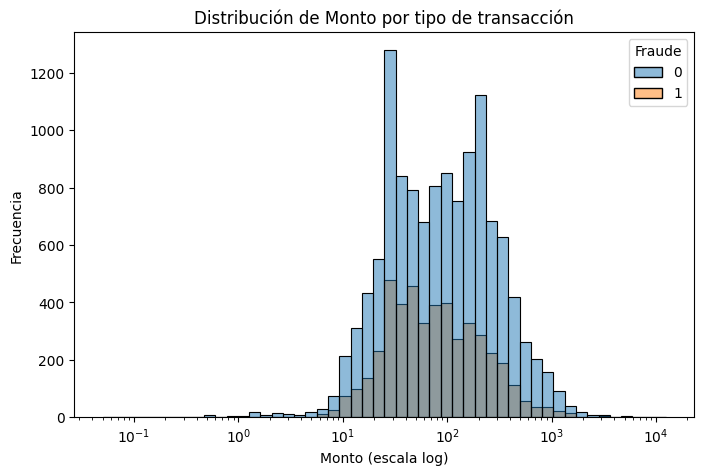

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(data=df, x="Monto", hue="Fraude", bins=50, log_scale=True, kde=False)
plt.title("Distribución de Monto por tipo de transacción")
plt.xlabel("Monto (escala log)")
plt.ylabel("Frecuencia")
plt.show()


**Balance de clases**

Ver desbalance de clases


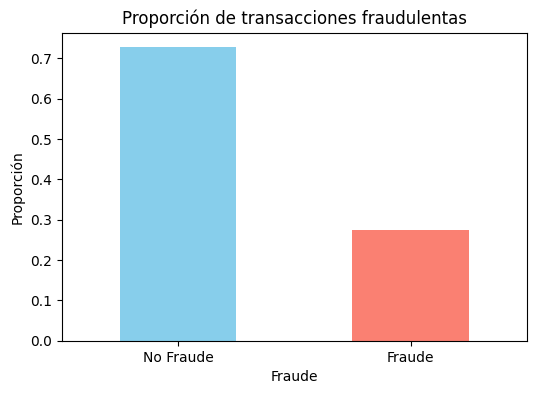

In [17]:
df["Fraude"].value_counts(normalize=True).plot(
    kind="bar", figsize=(6,4), color=["skyblue","salmon"]
)
plt.title("Proporción de transacciones fraudulentas")
plt.xticks([0,1], ["No Fraude","Fraude"], rotation=0)
plt.ylabel("Proporción")
plt.show()


**Curva ROC**

enseña discriminación del modelo.

In [18]:
from sklearn.metrics import roc_curve, auc

p = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("Curva ROC")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.show()


NameError: name 'pipe' is not defined

In [19]:
# === 2. Train/Test split ===
y = df["Fraude"].astype(int)
X = df.drop(columns=["Fraude"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

amounts_test = X_test["Monto"].to_numpy()

# Columnas numéricas y categóricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])


**Probemos modelos de ML**

In [20]:
#  Entrenamiento de modelos
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
}

results = []

for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    pipe.fit(X_train, y_train)
    p = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, p)
    ap = average_precision_score(y_test, p)

    thresholds = np.linspace(0.0, 0.9, 181)
    profits = np.array([profit_at_threshold(y_test.to_numpy(), p, t, amounts_test) for t in thresholds])

    idx = int(np.argmax(profits))
    best_t = float(thresholds[idx])
    best_p = float(profits[idx])

    results.append({
        "model": name,
        "roc_auc": auc,
        "avg_precision": ap,
        "best_threshold": best_t,
        "best_profit": best_p,
        "profit_at_t_0.2": profit_at_threshold(y_test.to_numpy(), p, 0.2, amounts_test)
    })

results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,roc_auc,avg_precision,best_threshold,best_profit,profit_at_t_0.2
0,LogisticRegression,0.768967,0.563830,0.360,50862.0175,25764.7675
1,HistGradientBoosting,0.831585,0.695815,0.190,63476.0350,63150.3400
2,RandomForest,0.817396,0.674533,0.200,59628.1025,59628.1025
3,GradientBoosting,0.816582,0.672387,0.290,60052.0575,57434.5675
4,SVM,0.531157,0.322591,0.245,9666.1925,0.0000


In [21]:
#  Reporte  para el mejor modelo
best_model = results_df.sort_values(by="best_profit", ascending=False).iloc[0]
print("Mejor modelo:\n", best_model)

chosen = best_model["model"]

pipe = Pipeline(steps=[("preprocess", preprocess), ("model", models[chosen])])
pipe.fit(X_train, y_train)
p = pipe.predict_proba(X_test)[:, 1]

y_pred = (p >= best_model["best_threshold"]).astype(int)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))


Mejor modelo:
 model              HistGradientBoosting
roc_auc                        0.831585
avg_precision                  0.695815
best_threshold                     0.19
best_profit                   63476.035
profit_at_t_0.2                63150.34
Name: 1, dtype: object
Matriz de confusión:
[[1965 1102]
 [ 183  970]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9148    0.6407    0.7536      3067
           1     0.4681    0.8413    0.6016      1153

    accuracy                         0.6955      4220
   macro avg     0.6915    0.7410    0.6776      4220
weighted avg     0.7928    0.6955    0.7121      4220



**Curva ROC**

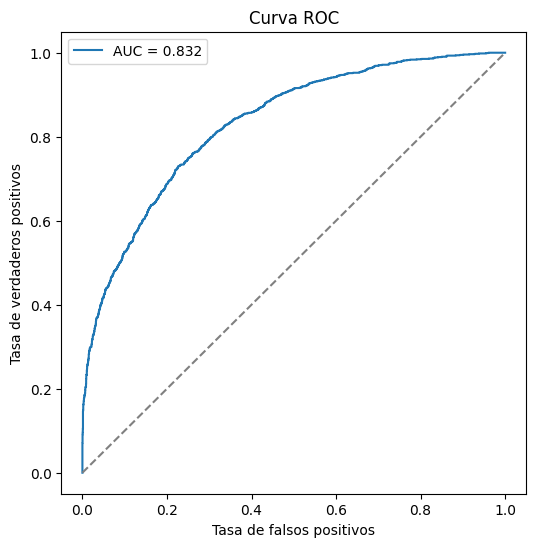

In [22]:
from sklearn.metrics import roc_curve, auc

p = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("Curva ROC")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.show()

**Curva de ganancia según umbral**

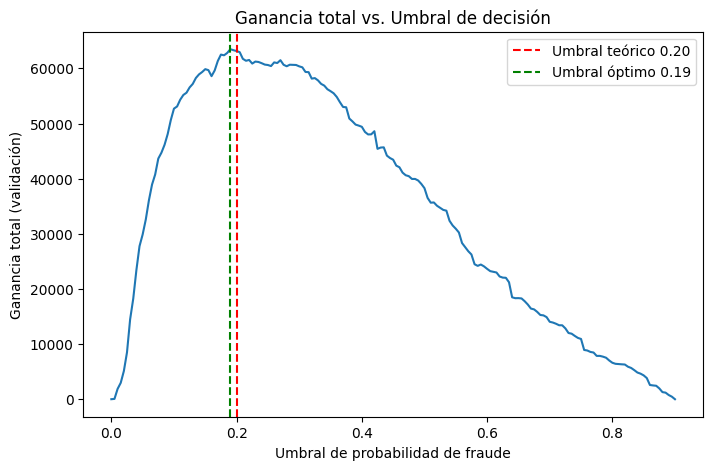

In [23]:
thresholds = np.linspace(0,0.9,181)
profits = [profit_at_threshold(y_test.to_numpy(), p, t, amounts_test) for t in thresholds]

plt.figure(figsize=(8,5))
plt.plot(thresholds, profits)
plt.axvline(0.2, color="red", linestyle="--", label="Umbral teórico 0.20")
plt.axvline(best_model["best_threshold"], color="green", linestyle="--",
            label=f"Umbral óptimo {best_model['best_threshold']:.2f}")
plt.title("Ganancia total vs. Umbral de decisión")
plt.xlabel("Umbral de probabilidad de fraude")
plt.ylabel("Ganancia total (validación)")
plt.legend()
plt.show()
